In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cab
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('darkgrid',{'font.sans-serif':'Microsoft YaHei'})
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
import math
import sklearn.metrics as metrics
import os, datetime, sys, random, time
import matplotlib.gridspec as gridspec
from mlxtend import classifier
import warnings
warnings.filterwarnings('ignore')
from scipy import stats, special
import shap
%matplotlib inline

## 导入数据 <a class="anchor" id="2"></a>

In [2]:
df_train = pd.read_csv("cs-training.csv",index_col=0)
df_test = pd.read_csv("cs-test.csv",index_col=0)
df_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


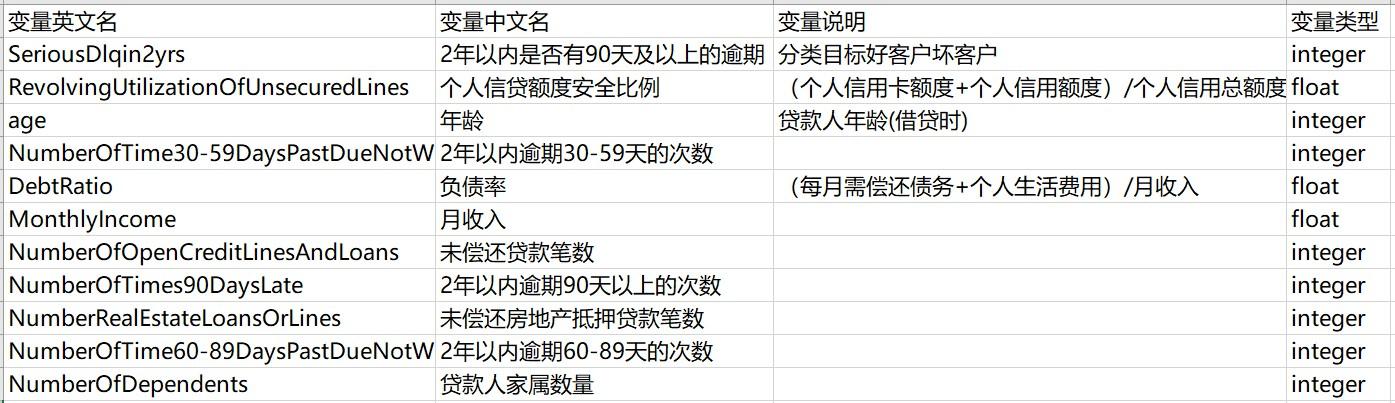

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [4]:
df_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


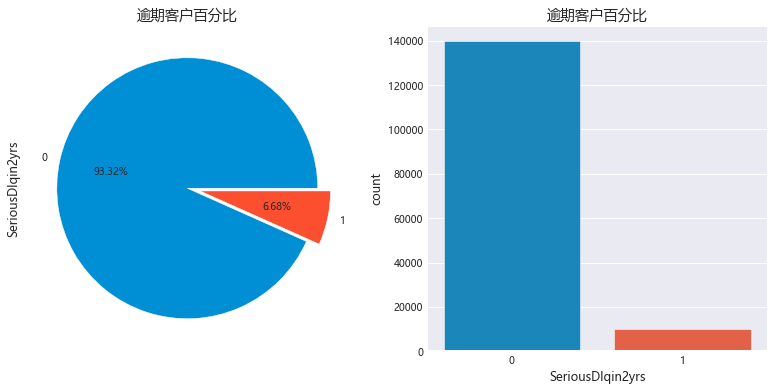

逾期客户的百分比:0.06684


In [5]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
df_train['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.2f%%',ax=axes[0])
axes[0].set_title('逾期客户百分比')
sns.countplot('SeriousDlqin2yrs',data=df_train,ax=axes[1])
axes[1].set_title('逾期客户百分比')
plt.show()
print("逾期客户的百分比:{}".format(df_train["SeriousDlqin2yrs"].sum() / len(df_train)))

### 数据探索

Text(0.5, 1.0, 'Correlation Matrix (热力图)')

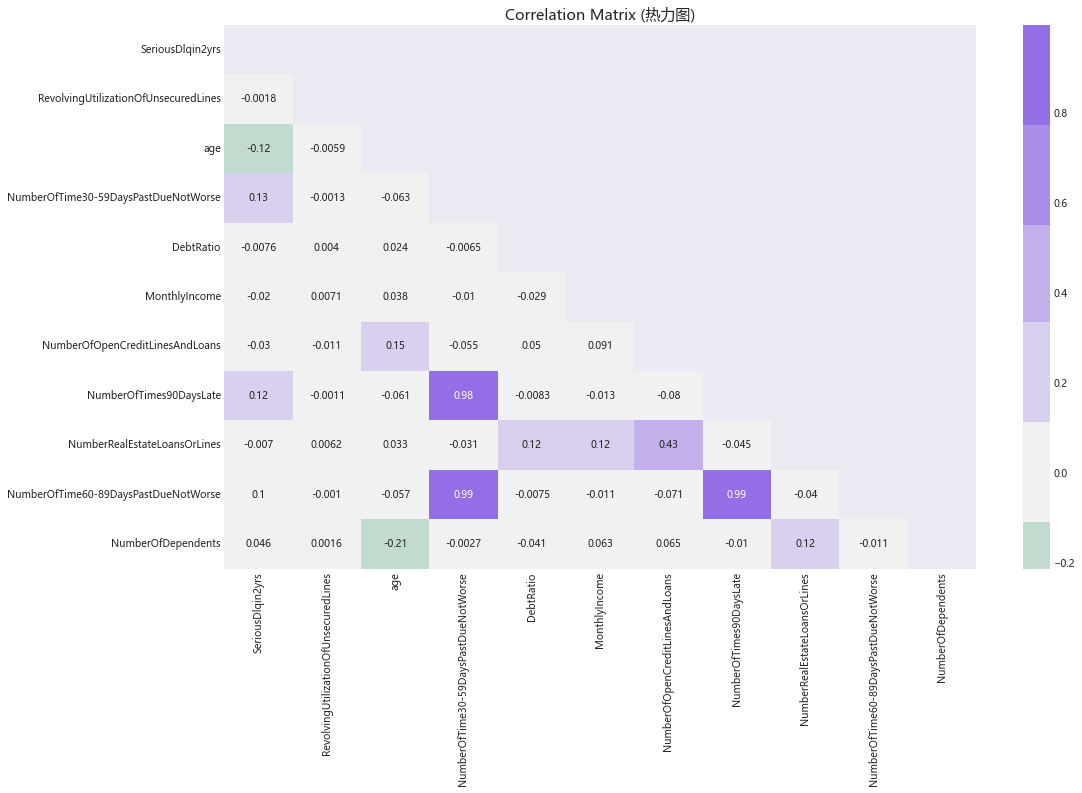

In [6]:
fig = plt.figure(figsize = [15,10])
mask = np.zeros_like(df_train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_train.corr(), cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9), mask = mask, annot=True, center = 0)
plt.title("Correlation Matrix (热力图)", fontsize = 15)

### 异常值检测

### RevolvingUtilizationOfUnsecuredLines（个人信贷额度安全比例）

In [7]:
df_train["RevolvingUtilizationOfUnsecuredLines"].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [8]:
default_prop = []
for i in range(int(df_train["RevolvingUtilizationOfUnsecuredLines"].max())):
    temp_ = df_train.loc[df_train["RevolvingUtilizationOfUnsecuredLines"] >= i]
    default_prop.append([i, temp_["SeriousDlqin2yrs"].mean()])
default_prop

[[0, 0.06684],
 [1, 0.37177950868783705],
 [2, 0.14555256064690028],
 [3, 0.09931506849315068],
 [4, 0.08679245283018867],
 [5, 0.07874015748031496],
 [6, 0.07692307692307693],
 [7, 0.0778688524590164],
 [8, 0.07407407407407407],
 [9, 0.07053941908713693],
 [10, 0.07053941908713693],
 [11, 0.07053941908713693],
 [12, 0.06666666666666667],
 [13, 0.058823529411764705],
 [14, 0.058823529411764705],
 [15, 0.05531914893617021],
 [16, 0.05531914893617021],
 [17, 0.05531914893617021],
 [18, 0.05531914893617021],
 [19, 0.05555555555555555],
 [20, 0.05555555555555555],
 [21, 0.05555555555555555],
 [22, 0.05555555555555555],
 [23, 0.05555555555555555],
 [24, 0.05555555555555555],
 [25, 0.05555555555555555],
 [26, 0.05555555555555555],
 [27, 0.05555555555555555],
 [28, 0.05555555555555555],
 [29, 0.05555555555555555],
 [30, 0.05150214592274678],
 [31, 0.05150214592274678],
 [32, 0.05150214592274678],
 [33, 0.05150214592274678],
 [34, 0.05150214592274678],
 [35, 0.05150214592274678],
 [36, 0.05150

Text(0.5, 1.0, '逾期客户比例与个人信贷额度安全比例的关系')

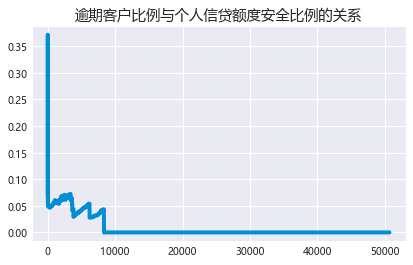

In [9]:
sns.lineplot(x=[i[0] for i in default_prop], y=[i[1] for i in default_prop])
plt.title("逾期客户比例与个人信贷额度安全比例的关系")

通过以上分析统计，个人信贷额度安全比例大于1的客户作为异常值直接删除

In [10]:
df_train =df_train[(df_train['RevolvingUtilizationOfUnsecuredLines']>=0)&(df_train['RevolvingUtilizationOfUnsecuredLines']<=1)]

### age

In [11]:
df_train["age"].describe()

count    146679.000000
mean         52.481766
std          14.763178
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='Density'>

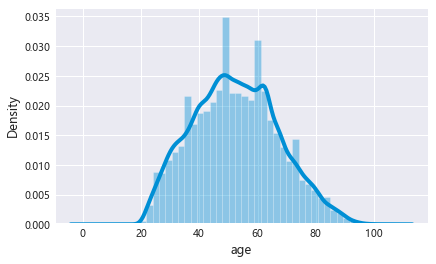

In [12]:
sns.distplot(df_train["age"])

<AxesSubplot:xlabel='age', ylabel='Density'>

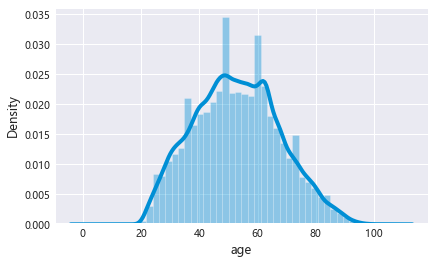

In [13]:
sns.distplot(df_train.loc[df_train["SeriousDlqin2yrs"] == 0]["age"])

<AxesSubplot:xlabel='age', ylabel='Density'>

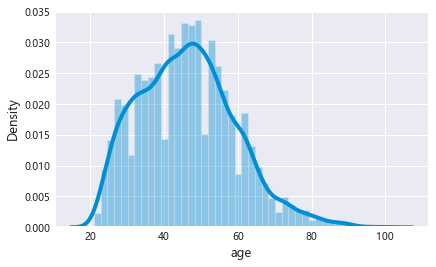

In [14]:
sns.distplot(df_train.loc[df_train["SeriousDlqin2yrs"] == 1]["age"])

[Text(1, 0, '借贷人年龄')]

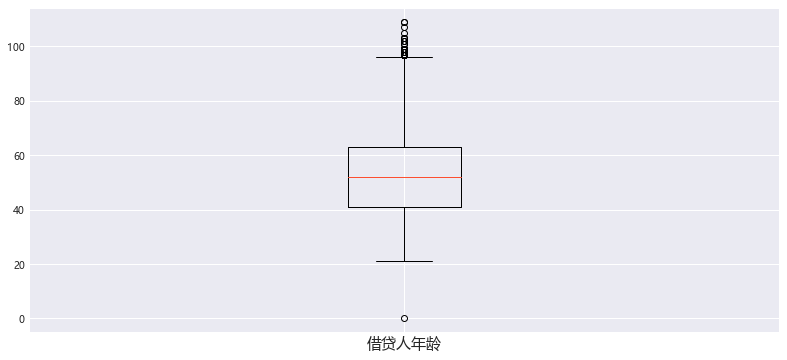

In [15]:
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot()
ax1.boxplot(df_train['age'])
ax1.set_xticklabels(["借贷人年龄"], fontsize=15)

In [16]:
df_train["age"].quantile(0.99)

87.0

通过以上分析统计和信贷常识，借贷人年龄小于22岁和大于87的客户作为异常值直接删除

In [17]:
df_train =df_train[(df_train['age']>=22)&(df_train['age']<=87)]

逾期90天的次数
逾期60-89天次数
逾期30-59天次数

In [18]:
late_pay_cols = ["NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse",
                "NumberOfTime30-59DaysPastDueNotWorse"]
df_train["NumberOfTimes90DaysLate"].value_counts().sort_index()

0     137945
1       4724
2       1309
3        532
4        230
5        100
6         62
7         26
8         15
9         16
10         7
11         4
12         1
13         2
14         2
15         1
17         1
96         5
98       242
Name: NumberOfTimes90DaysLate, dtype: int64

In [19]:
df_train["NumberOfTime60-89DaysPastDueNotWorse"].value_counts().sort_index()

0     138591
1       5127
2        890
3        241
4         79
5         26
6         13
7          6
8          2
9          1
11         1
96         5
98       242
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

In [20]:
df_train["NumberOfTime30-59DaysPastDueNotWorse"].value_counts().sort_index()

0     123077
1      15115
2       4143
3       1523
4        636
5        285
6        114
7         43
8         23
9         11
10         3
11         1
12         2
13         1
96         5
98       242
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

In [21]:
distinct_triples_counts = dict()
for arr in df_train.loc[df_train["NumberOfTimes90DaysLate"] > 17][late_pay_cols].values:
    triple = ",".join(list(map(str, arr)))
    if triple not in distinct_triples_counts:
        distinct_triples_counts[triple] = 0
    else:
        distinct_triples_counts[triple] += 1
distinct_triples_counts

{'98,98,98': 241, '96,96,96': 4}

[Text(1, 0, '逾期30-59天笔数'), Text(2, 0, '逾期60-89天笔数'), Text(3, 0, '逾期90天笔数')]

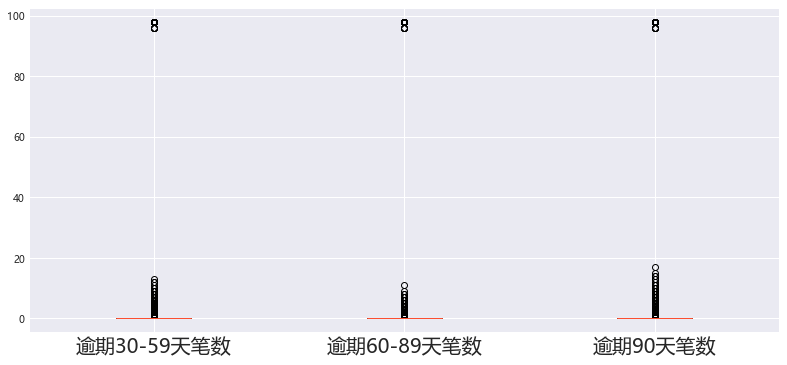

In [22]:
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot()
ax1.boxplot([df_train["NumberOfTime30-59DaysPastDueNotWorse"],df_train["NumberOfTime60-89DaysPastDueNotWorse"],df_train["NumberOfTimes90DaysLate"]])
ax1.set_xticklabels(["逾期30-59天笔数","逾期60-89天笔数","逾期90天笔数"], fontsize=20)

通过以上箱型图，分别删除逾期30-59天笔数，逾期60-89天笔数，逾期90天笔数中的超级离群数据

In [23]:
df_train =df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']<14]
df_train =df_train[df_train['NumberOfTime60-89DaysPastDueNotWorse']<10]
df_train =df_train[df_train['NumberOfTimes90DaysLate']<18]

### 负债率和月收入

In [24]:
df_train["DebtRatio"].describe()

count    144976.000000
mean        358.109817
std        2060.379832
min           0.000000
25%           0.178299
50%           0.367944
75%           0.865678
max      329664.000000
Name: DebtRatio, dtype: float64

In [25]:
df_train["MonthlyIncome"].describe()

count    1.164910e+05
mean     6.723255e+03
std      1.457596e+04
min      0.000000e+00
25%      3.446500e+03
50%      5.417000e+03
75%      8.310000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

[Text(1, 0, '负债率')]

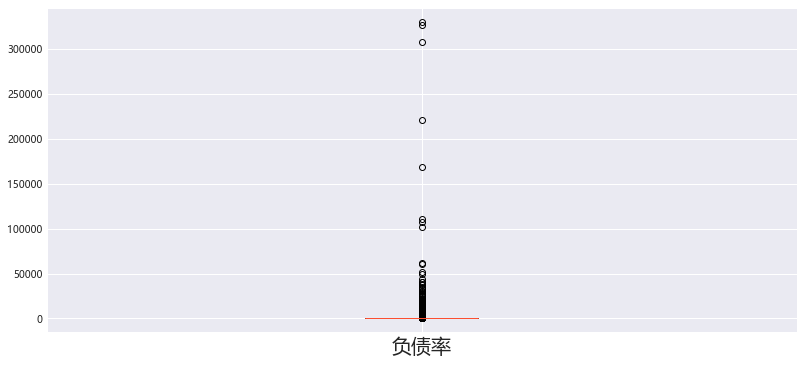

In [26]:
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot()
ax1.boxplot(df_train["DebtRatio"])
ax1.set_xticklabels(["负债率"], fontsize=20)

<AxesSubplot:ylabel='MonthlyIncome'>

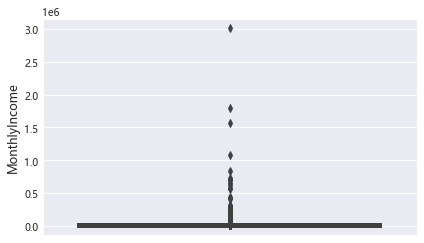

In [27]:
sns.boxplot(y=df_train["MonthlyIncome"])

In [28]:
df_train["DebtRatio"].quantile(0.99)

5007.25

In [29]:
df_train["MonthlyIncome"].quantile(0.99)

25000.0

通过以上箱型图，分别删除负债率大于4980，月收入大于23000美元的超级离群数据

In [30]:
df_train =df_train[df_train['DebtRatio']<=4980]
df_train =df_train[df_train['MonthlyIncome']<=23000]

### 未偿还贷款笔数

In [31]:
df_train["NumberOfOpenCreditLinesAndLoans"].describe()

count    114936.000000
mean          8.804004
std           5.147858
min           0.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [32]:
df_train["NumberOfOpenCreditLinesAndLoans"].value_counts()

6     10337
7     10321
8      9900
5      9550
9      9102
4      8225
10     7808
11     6773
3      6201
12     5739
13     4697
2      4289
14     3793
15     3045
1      2701
16     2503
17     1961
18     1541
19     1184
0       991
20      987
21      712
22      559
23      445
24      341
25      277
26      202
27      164
28      125
29       95
30       72
31       62
32       48
33       34
34       30
35       22
36       16
38       10
39        9
40        8
42        7
45        6
37        6
43        5
48        5
54        4
49        4
41        3
52        3
56        2
46        2
51        2
50        2
47        2
44        1
57        1
58        1
53        1
Name: NumberOfOpenCreditLinesAndLoans, dtype: int64

[Text(1, 0, '未偿还贷款笔数')]

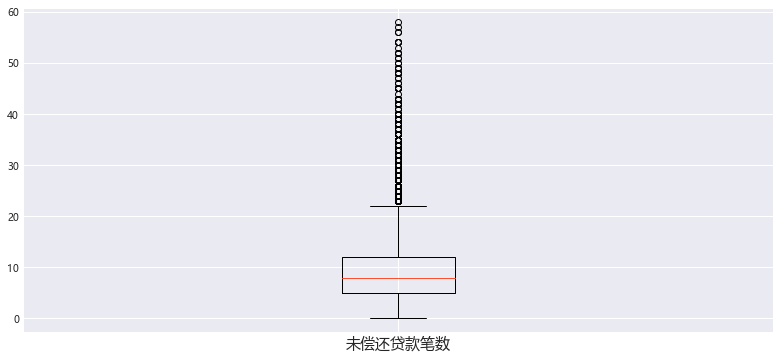

In [33]:
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot()
ax1.boxplot(df_train['NumberOfOpenCreditLinesAndLoans'])
ax1.set_xticklabels(["未偿还贷款笔数"], fontsize=15)

In [34]:
df_train["NumberOfOpenCreditLinesAndLoans"].quantile(0.99)

25.0

### 未偿还房地产抵押贷款笔数

In [35]:
df_train["NumberRealEstateLoansOrLines"].describe()

count    114936.000000
mean          1.055544
std           1.117795
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

In [36]:
df_train["NumberRealEstateLoansOrLines"].value_counts()

0     40833
1     40412
2     25757
3      5108
4      1713
5       525
6       248
7       121
8        72
9        55
10       29
11       14
12       14
13       12
14        6
15        5
16        3
17        2
19        2
54        1
18        1
23        1
25        1
20        1
Name: NumberRealEstateLoansOrLines, dtype: int64

<AxesSubplot:xlabel='NumberRealEstateLoansOrLines', ylabel='count'>

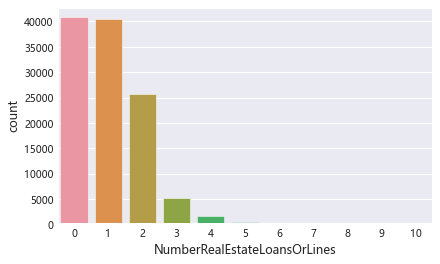

In [37]:
sns.countplot(x="NumberRealEstateLoansOrLines", data=df_train.loc[df_train["NumberRealEstateLoansOrLines"] <= 10])

In [38]:
df_train["NumberRealEstateLoansOrLines"].quantile(0.99)

4.0

In [39]:
df_train.loc[df_train["NumberRealEstateLoansOrLines"] > 13]["SeriousDlqin2yrs"].describe()

count    23.000000
mean      0.217391
std       0.421741
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: SeriousDlqin2yrs, dtype: float64

### 家属人数

In [40]:
df_train["NumberOfDependents"].describe()

count    114936.000000
mean          0.847524
std           1.144355
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

In [41]:
df_train["NumberOfDependents"].value_counts()

0.0     62670
1.0     23344
2.0     17266
3.0      8306
4.0      2495
5.0       634
6.0       143
7.0        46
8.0        21
10.0        5
9.0         4
20.0        1
13.0        1
Name: NumberOfDependents, dtype: int64

In [42]:
df_train.loc[df_train["NumberOfDependents"] <= 10]["SeriousDlqin2yrs"].describe()

count    114934.000000
mean          0.062036
std           0.241221
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: SeriousDlqin2yrs, dtype: float64

<AxesSubplot:xlabel='NumberOfDependents', ylabel='count'>

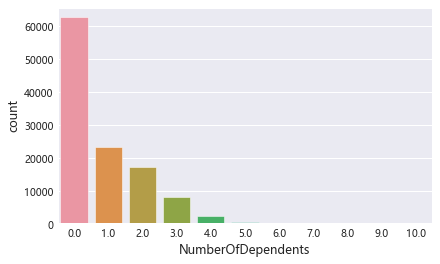

In [43]:
sns.countplot(x="NumberOfDependents", data=df_train.loc[df_train["NumberOfDependents"] <= 10])

In [44]:
def MissingHandler(df):
    DataMissing = df.isnull().sum()*100/len(df)
    DataMissingByColumn = pd.DataFrame({'Percentage Nulls':DataMissing})
    DataMissingByColumn.sort_values(by='Percentage Nulls',ascending=False,inplace=True)
    return DataMissingByColumn[DataMissingByColumn['Percentage Nulls']>0]

MissingHandler(df_train)

,Percentage Nulls


数据清洗
通过fillna函数将数据中的Nan填充为中位数

In [45]:
df_train = df_train.fillna(df_train.median())
df_train.to_csv("data.csv")#将数据清洗的样本保存到本地准备提交到Tableau和Spark数据库进行处理
print(df_train.isnull().sum())

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


### 特征工程 WOEIV码计算

In [46]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114936 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      114936 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  114936 non-null  float64
 2   age                                   114936 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  114936 non-null  int64  
 4   DebtRatio                             114936 non-null  float64
 5   MonthlyIncome                         114936 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       114936 non-null  int64  
 7   NumberOfTimes90DaysLate               114936 non-null  int64  
 8   NumberRealEstateLoansOrLines          114936 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  114936 non-null  int64  
 10  NumberOfDependents                    114936 non-null  float64
dtype

In [47]:
df_train['NumberOfTime60-89DaysPastDueNotWorse'].describe()

count    114936.000000
mean          0.059233
std           0.309318
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

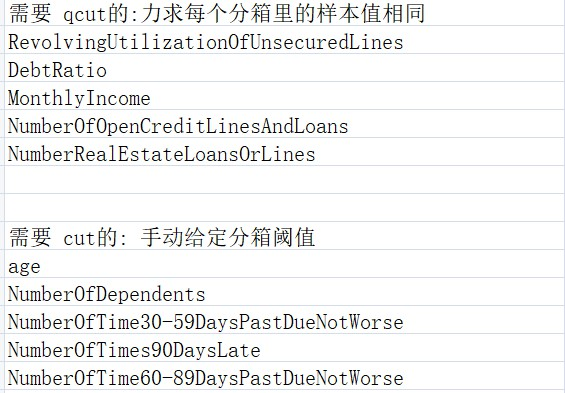

In [48]:
age_bins = [-math.inf, 22,35, 50, 65, math.inf]
df_train['bin_age'] = pd.cut(df_train['age'],bins=age_bins).astype(str)
dependent_bin = [-math.inf,2,4,6,8,10,math.inf]
df_train['bin_NumberOfDependents'] = pd.cut(df_train['NumberOfDependents'],bins=dependent_bin).astype(str)
dpd_bins = [-math.inf,1,2,3,4,5,6,7,8,9,10,math.inf]
df_train['bin_NumberOfTimes90DaysLate'] = pd.cut(df_train['NumberOfTimes90DaysLate'],bins=dpd_bins)
df_train['bin_NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime30-59DaysPastDueNotWorse'], bins=dpd_bins)
df_train['bin_NumberOfTime60-89DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime60-89DaysPastDueNotWorse'], bins=dpd_bins)


df_train['bin_RevolvingUtilizationOfUnsecuredLines'] = pd.qcut(df_train['RevolvingUtilizationOfUnsecuredLines'],q=5,duplicates='drop').astype(str)
df_train['bin_DebtRatio'] = pd.qcut(df_train['DebtRatio'],q=5,duplicates='drop').astype(str)
df_train['bin_MonthlyIncome'] = pd.qcut(df_train['MonthlyIncome'],q=5,duplicates='drop').astype(str)
df_train['bin_NumberOfOpenCreditLinesAndLoans'] = pd.qcut(df_train['NumberOfOpenCreditLinesAndLoans'],q=5,duplicates='drop').astype(str)
df_train['bin_NumberRealEstateLoansOrLines'] = pd.qcut(df_train['NumberRealEstateLoansOrLines'],q=5,duplicates='drop').astype(str)

In [49]:
bin_cols = [c for c in df_train.columns.values if c.startswith('bin_')]

In [50]:
#计算information value信息值函数
def cal_IV(df, feature, target):
    lst = []
    cols=['Variable', 'Value', 'All', 'Bad']
    for i in range(df[feature].nunique()):
        
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], df[(df[feature] == val) & (df[target] == 1)].count()[feature]])

    data = pd.DataFrame(lst, columns=cols)
    data = data[data['Bad'] > 0]

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log( data['Distribution Bad']/data['Distribution Good'])
    data['IV'] = (data['WoE'] * (data['Distribution Bad']-data['Distribution Good'] )).sum()

    data = data.sort_values(by=['Variable', 'Value'], ascending=True)

    return data['IV'].values[0]

In [51]:
for f in bin_cols:
    print(f)
    print(cal_IV(df_train,f,'SeriousDlqin2yrs'))

bin_age
0.16152972085517012
bin_NumberOfDependents
0.014829862830186162
bin_NumberOfTimes90DaysLate
0.38193041778693637
bin_NumberOfTime30-59DaysPastDueNotWorse
0.4009550329860645
bin_NumberOfTime60-89DaysPastDueNotWorse
0.18432495596395507
bin_RevolvingUtilizationOfUnsecuredLines
0.8221234250040965
bin_DebtRatio
0.0750315368798553
bin_MonthlyIncome
0.06231672892071547
bin_NumberOfOpenCreditLinesAndLoans
0.03300033824386657
bin_NumberRealEstateLoansOrLines
0.012554891618774645


只选择信息值>0.1具有中等预测效果的信息值的，入选的有五个变量：

bin_RevolvingUtilizationOfUnsecuredLines bin_NumberOfTime30-59DaysPastDueNotWorse bin_age bin_NumberOfTimes90DaysLate bin_NumberOfTime60-89DaysPastDueNotWorse

In [52]:
#定义WOE证据权重的函数
def cal_WOE(df,features,target):
    df_new = df
    for f in features:
        df_woe = df_new.groupby(f).agg({target:['sum','count']})
        df_woe.columns = list(map(''.join, df_woe.columns.values))
        df_woe = df_woe.reset_index()
        df_woe = df_woe.rename(columns = {target+'sum':'bad'})
        df_woe = df_woe.rename(columns = {target+'count':'all'})
        df_woe['good'] = df_woe['all']-df_woe['bad']
        df_woe = df_woe[[f,'good','bad']]
        df_woe['bad_rate'] = df_woe['bad'].mask(df_woe['bad']==0,1)/df_woe['bad'].sum()
        df_woe['good_rate'] = df_woe['good']/df_woe['good'].sum()
        
        df_woe['woe'] = np.log(df_woe['bad_rate'].divide(df_woe['good_rate'],fill_value=1))        
        df_woe.columns = [c if c==f else c+'_'+f for c in list(df_woe.columns.values)]
        df_new = df_new.merge(df_woe,on=f,how='left')
    return df_new

In [53]:
# 我们根据信息值选出来的特征
feature_cols = ['RevolvingUtilizationOfUnsecuredLines','NumberOfTime30-59DaysPastDueNotWorse','age','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse']
bin_cols = ['bin_RevolvingUtilizationOfUnsecuredLines','bin_NumberOfTime30-59DaysPastDueNotWorse','bin_age','bin_NumberOfTimes90DaysLate','bin_NumberOfTime60-89DaysPastDueNotWorse']
df_woe = cal_WOE(df_train,bin_cols,'SeriousDlqin2yrs')
woe_cols = [c for c in list(df_woe.columns.values) if 'woe' in c]
df_woe[woe_cols]

,woe_bin_RevolvingUtilizationOfUnsecuredLines,woe_bin_NumberOfTime30-59DaysPastDueNotWorse,woe_bin_age,woe_bin_NumberOfTimes90DaysLate,woe_bin_NumberOfTime60-89DaysPastDueNotWorse
0,1.118388,1.537739,0.217610,-0.136784,-0.069174
1,1.118388,-0.221966,0.217610,-0.136784,-0.069174
2,0.118531,-0.221966,0.217610,-0.136784,-0.069174
3,-0.667919,-0.221966,0.448398,-0.136784,-0.069174
4,-0.667919,-0.221966,-0.923492,-0.136784,-0.069174
...,...,...,...,...,...
114931,0.118531,-0.221966,0.217610,-0.136784,-0.069174
114932,-1.243993,-0.221966,-0.923492,-0.136784,-0.069174
114933,0.118531,-0.221966,0.217610,-0.136784,-0.069174
114934,-1.123341,-0.221966,0.448398,-0.136784,-0.069174


In [54]:
df_bin_to_woe = pd.DataFrame(columns = ['features','bin','woe'])
for f in feature_cols:
    b = 'bin_'+f
    w = 'woe_bin_'+f
    df = df_woe[[w,b]].drop_duplicates()
    df.columns = ['woe','bin']
    df['features'] = f
    df=df[['features','bin','woe']]
    df_bin_to_woe = pd.concat([df_bin_to_woe,df])
df_bin_to_woe

,features,bin,woe
0,RevolvingUtilizationOfUnsecuredLines,"(0.66, 1.0]",1.118388
2,RevolvingUtilizationOfUnsecuredLines,"(0.282, 0.66]",0.118531
3,RevolvingUtilizationOfUnsecuredLines,"(0.0934, 0.282]",-0.667919
7,RevolvingUtilizationOfUnsecuredLines,"(-0.001, 0.0222]",-1.123341
16,RevolvingUtilizationOfUnsecuredLines,"(0.0222, 0.0934]",-1.243993
0,NumberOfTime30-59DaysPastDueNotWorse,"(1.0, 2.0]",1.537739
1,NumberOfTime30-59DaysPastDueNotWorse,"(-inf, 1.0]",-0.221966
9,NumberOfTime30-59DaysPastDueNotWorse,"(2.0, 3.0]",1.956456
162,NumberOfTime30-59DaysPastDueNotWorse,"(3.0, 4.0]",2.344459
341,NumberOfTime30-59DaysPastDueNotWorse,"(9.0, 10.0]",2.716022


逻辑回归LR建模

70%作为模型的训练集，留30%作为模型的验证集

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df_woe[woe_cols], df_woe['SeriousDlqin2yrs'], test_size=0.3, random_state=37)

In [56]:
print('bad rate is: ',y_train.mean())

bad rate is:  0.06112733826362563


In [57]:
model_LR = LogisticRegression(random_state=37).fit(X_train,y_train)

In [58]:
model_LR.score(X_test,y_test)

0.9379658362576492

In [59]:
yPredLR = model_LR.predict_proba(X_test)
yPredLR = yPredLR[:,1]

In [60]:
yTestPredLR = model_LR.predict(X_test)
print(metrics.classification_report(y_test,yTestPredLR))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     32269
           1       0.62      0.09      0.15      2212

    accuracy                           0.94     34481
   macro avg       0.78      0.54      0.56     34481
weighted avg       0.92      0.94      0.92     34481



In [61]:
metrics.confusion_matrix(y_test,yTestPredLR)

array([[32152,   117],
       [ 2022,   190]], dtype=int64)

In [62]:
LRMetrics = pd.DataFrame({'Model': 'LogisticRegression', 
                            'MSE': round(metrics.mean_squared_error(y_test, yTestPredLR)*100,2),
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test, yTestPredLR)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(y_test, yTestPredLR)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(y_test, yTestPredLR)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(y_test, yTestPredLR)*100),2),
                            'Accuracy Train' : round(model_LR.score(X_train, y_train) * 100,2),
                            'Accuracy Test' : round(model_LR.score(X_test, y_test) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(y_test, yTestPredLR, beta=2)*100,2)},index=[0])

LRMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
0,LogisticRegression,6.2,2.49,6.2,2.98,1.73,94.05,93.8,10.38


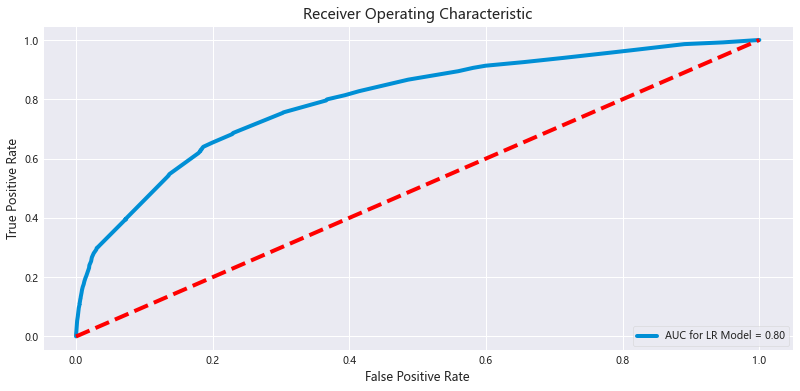

In [63]:
fpr_LR,tpr_LR,_ = metrics.roc_curve(y_test,yPredLR)
ROC_AUC_LR= metrics.auc(fpr_LR, tpr_LR)
plt.figure(figsize=(12,6))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr_LR, tpr_LR, label = 'AUC for LR Model = %0.2f' % ROC_AUC_LR)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 评分卡计算

In [64]:
#设定600分作为基准分，比率翻番时分数变化值为50分，可计算出如下结果
A = 600
B =72.13

In [65]:
#定义评分卡的函数
def generate_scorecard(model_coef,binning_df,features,B):
    lst = []
    cols = ['Variable','Binning','Score']
    coef = model_coef[0]
    for i in range(len(features)):
        f = features[i]
        df = binning_df[binning_df['features']==f]
        for index,row in df.iterrows():
            lst.append([f,row['bin'],int(round(-coef[i]*row['woe']*B))])
    data = pd.DataFrame(lst, columns=cols)
    return data

In [66]:
score_card = generate_scorecard(model_LR.coef_,df_bin_to_woe,feature_cols,B)
score_card

,Variable,Binning,Score
0,RevolvingUtilizationOfUnsecuredLines,"(0.66, 1.0]",-63
1,RevolvingUtilizationOfUnsecuredLines,"(0.282, 0.66]",-7
2,RevolvingUtilizationOfUnsecuredLines,"(0.0934, 0.282]",37
3,RevolvingUtilizationOfUnsecuredLines,"(-0.001, 0.0222]",63
4,RevolvingUtilizationOfUnsecuredLines,"(0.0222, 0.0934]",70
5,NumberOfTime30-59DaysPastDueNotWorse,"(1.0, 2.0]",-74
6,NumberOfTime30-59DaysPastDueNotWorse,"(-inf, 1.0]",11
7,NumberOfTime30-59DaysPastDueNotWorse,"(2.0, 3.0]",-94
8,NumberOfTime30-59DaysPastDueNotWorse,"(3.0, 4.0]",-113
9,NumberOfTime30-59DaysPastDueNotWorse,"(9.0, 10.0]",-131


In [67]:
sort_scorecard = score_card.groupby('Variable').apply(lambda x: x.sort_values('Score', ascending=False))
sort_scorecard

Variable  \
Variable                                                                        
NumberOfTime30-59DaysPastDueNotWorse 6   NumberOfTime30-59DaysPastDueNotWorse   
                                     5   NumberOfTime30-59DaysPastDueNotWorse   
                                     7   NumberOfTime30-59DaysPastDueNotWorse   
                                     14  NumberOfTime30-59DaysPastDueNotWorse   
                                     15  NumberOfTime30-59DaysPastDueNotWorse   
                                     8   NumberOfTime30-59DaysPastDueNotWorse   
                                     10  NumberOfTime30-59DaysPastDueNotWorse   
                                     11  NumberOfTime30-59DaysPastDueNotWorse   
                                     9   NumberOfTime30-59DaysPastDueNotWorse   
                                     12  NumberOfTime30-59DaysPastDueNotWorse   
                                     13  NumberOfTime30-59DaysPastDueNotWorse   
NumberOfTime60-89DaysPastDueNotWorse 32  NumberOfTime60-89DaysPastDueNotWorse   
                                     33  NumberOfTime60-89DaysPastDueNotWorse   
                                     38  NumberOfTime60-89DaysPastDueNotWorse   
                                     39  NumberOfTime60-89DaysPastDueNotWorse   
                                     40  NumberOfTime60-89DaysPastDueNotWorse   
                                     35  NumberOfTime60-89DaysPastDueNotWorse   
                                     34  NumberOfTime60-89DaysPastDueNotWorse   
                                     36  NumberOfTime60-89DaysPastDueNotWorse   
                                     37  NumberOfTime60-89DaysPastDueNotWorse   
NumberOfTimes90DaysLate              21               NumberOfTimes90DaysLate   
                                     23               NumberOfTimes90DaysLate   
                                     31               NumberOfTimes90DaysLate   
                                     22               NumberOfTimes90DaysLate   
                                     27               NumberOfTimes90DaysLate   
                                     25               NumberOfTimes90DaysLate   
                                     26               NumberOfTimes90DaysLate   
                                     30               NumberOfTimes90DaysLate   
                                     24               NumberOfTimes90DaysLate   
                                     28               NumberOfTimes90DaysLate   
                                     29               NumberOfTimes90DaysLate   
RevolvingUtilizationOfUnsecuredLines 4   RevolvingUtilizationOfUnsecuredLines   
                                     3   RevolvingUtilizationOfUnsecuredLines   
                                     2   RevolvingUtilizationOfUnsecuredLines   
                                     1   RevolvingUtilizationOfUnsecuredLines   
                                     0   RevolvingUtilizationOfUnsecuredLines   
age                                  18                                   age   
                                     20                                   age   
                                     19                                   age   
                                     16                                   age   
                                     17                                   age   

                                                  Binning  Score  
Variable                                                          
NumberOfTime30-59DaysPastDueNotWorse 6        (-inf, 1.0]     11  
                                     5         (1.0, 2.0]    -74  
                                     7         (2.0, 3.0]    -94  
                                     14        (7.0, 8.0]    -97  
                                     15        (8.0, 9.0]    -97  
                                     8         (3.0, 4.0]   -113  
                                     10        (4

In [68]:
# 把输入数据映射到分箱，并且选取相应的分值来计算最后的信用评分
def str_to_int(s):
    if s == '-inf':
        return -999999999.0
    elif s=='inf':
        return 999999999.0
    else:
        return float(s)
    
def map_value_to_bin(feature_value,feature_to_bin):
    for idx, row in feature_to_bin.iterrows():
        bins = str(row['Binning'])
        left_open = bins[0]=="("
        right_open = bins[-1]==")"
        binnings = bins[1:-1].split(',')
        in_range = True
        # check left bound
        if left_open:
            if feature_value<= str_to_int(binnings[0]):
                in_range = False   
        else:
            if feature_value< str_to_int(binnings[0]):
                in_range = False   
        #check right bound
        if right_open:
            if feature_value>= str_to_int(binnings[1]):
                in_range = False 
        else:
            if feature_value> str_to_int(binnings[1]):
                in_range = False   
        if in_range:
            return row['Binning']
    return null

def map_to_score(df,score_card):
    scored_columns = list(score_card['Variable'].unique())
    score = 0
    for col in scored_columns:
        feature_to_bin = score_card[score_card['Variable']==col]
        feature_value = df[col]
        selected_bin = map_value_to_bin(feature_value,feature_to_bin)
        selected_record_in_scorecard = feature_to_bin[feature_to_bin['Binning'] == selected_bin]
        score += selected_record_in_scorecard['Score'].iloc[0]
    return score  

def calculate_score_with_card(df,score_card,A):
    df['score'] = df.apply(map_to_score,args=(score_card,),axis=1)
    df['score'] = df['score']+A
    df['score'] = df['score'].astype(int)
    return df

In [69]:
good_sample = df_train[df_train['SeriousDlqin2yrs']==0].sample(5, random_state=6)
good_sample = good_sample[feature_cols]
bad_sample = df_train[df_train['SeriousDlqin2yrs']==1].sample(5, random_state=6)
bad_sample = bad_sample[feature_cols]

In [70]:
calculate_score_with_card(good_sample,score_card,A)

,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,age,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,score
130067,0.000000,0,48,0,0,674
54480,0.016159,0,69,0,0,717
15271,0.012511,0,54,0,0,689
66641,0.001750,0,75,0,0,717
124581,0.014009,0,55,0,0,689


In [71]:
calculate_score_with_card(bad_sample,score_card,A)

,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,age,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,score
107442,0.207983,1,27,1,0,639
120314,0.634592,1,45,0,0,604
13569,0.920620,1,44,0,0,548
115810,1.000000,0,56,2,1,437
101602,0.735628,1,41,0,0,548


可以看到，好的样本分数评分都比坏样本分数高，说明了评分卡的有效性。如上图所示，好的样本分数都是650以上，坏的样本都在650以下。能识别较多的坏客户。

总结:通过Python工具包pandas进行异常值、缺失值等数据清洗，连接Tableau至Spark数据库分析客户基础属性，收入状况，过往逾期情况，并进行可视化展示，通过分析展示结果设计不同的分箱策略计算客户每项数据的信息值，选取具有中等效果预测能力的客户属性来对客户进行逻辑回归建模，搭建AUC达0.80优质客户筛选模型，建立类芝麻信用评分识别客户 <a class="anchor" id="1"></a>